In [1]:
import copy
import random
import numpy as np
import matplotlib.pyplot as plt

# =================================
# Defining constants
# =================================

# fat
fat_shc = 1.9842e3 # J kg-1 K-1
fat_tc = 1.8071e-1 # W m-1 K-1
fat_density = 9.2559e2 # kg m-3

# protein
protein_shc = 2.0082e3 # J kg-1 K-1
protein_tc = 1.7881e-1 # W m-1 K-1
protein_density = 1.3299e3 # kg m-3

# pixel
pixel_side_length = 0.005 # meter

# temperatures
max_temperature = 220
room_temperature = 25 # celsius
heating_temperature = 200 # celsius
ideal_internal_temperature = 60 # celsius

In [2]:
def create_pixel(temperature, thermal_conductivity, specific_heat_capacity, density, heat_source):
    return [temperature, thermal_conductivity, specific_heat_capacity, density, heat_source]

def get_temp(pixel):
    return pixel[0]

def get_tc(pixel):
    return pixel[1]

def get_shc(pixel):
    return pixel[2]

def get_density(pixel):
    return pixel[3]

def get_src(pixel):
    return pixel[4]

def change_temp(pixel, new_temp):
    pixel[0] = new_temp

In [3]:
def create_steak(height, width, fat_percentage):
    res = []
    for i in range(height):
        tmp = []
        for j in range(width):
            if i < height - 1:
                random_float = random.random()
                if random_float < fat_percentage:
                    tmp.append(create_pixel(room_temperature,fat_tc,fat_shc, fat_density, False))
                else:
                    tmp.append(create_pixel(room_temperature,protein_tc,protein_shc, protein_density, False))
            else:
                tmp.append(create_pixel(heating_temperature,0,0,0,True))
        res.append(tmp)
    return res

In [4]:
def to_color(temp,min_temp = room_temperature, max_temp = max_temperature):
    temp = min_temp if temp < min_temp else max_temp if temp > max_temp else temp
    # if temp < min_temp or temp > max_temp:
    #     print(f"Please enter a temperature between {min_temp} and {max_temp}!")
    heat_index = (temp - min_temp)/(max_temp - min_temp)
    color = [heat_index,0.0,1-heat_index]
    return color

def get_color_map(image):
    image = list(list(get_temp(pixel) for pixel in row) for row in image)
    res = []
    for i in range(len(image)):
        tmp = []
        for j in range(len(image[0])):
            tmp.append(to_color(image[i][j]))
        res.append(tmp)
    return res

In [5]:
def step_pixel(image, i=0, j=0, t=0.01):

    # PART 1: GET THE TOP AND BOTTOM PIXEL DATA
    n_rows = np.shape(image)[0]
    n_cols = np.shape(image)[1]

    top = image[i-1,j] if i > 0 else None
    bottom = image[i+1,j] if i < n_rows-1 else None
    left = image[i,j-1] if j > 0 else None
    right = image[i,j+1] if j < n_cols-1 else None

    pixels_in_contact = np.array([x for x in [top,left,right,bottom] if x is not None])
    pixel_of_interest = image[i,j]

    # print(pixel_of_interest)
    # print(pixels_in_contact)

    # PART 2: CALCULATE FINAL TEMP OF PIXEL I,J
    ini_temp_diff = np.array(list(get_temp(pixel) for pixel in pixels_in_contact)) - get_temp(pixel_of_interest)
    # print(ini_temp_diff)
    heat_gain = np.sum(t * get_tc(pixel_of_interest) * pixel_side_length * ini_temp_diff)
    # print(heat_gain)
    change_in_temp = heat_gain / (pixel_side_length ** 3 * get_density(pixel_of_interest) * get_shc(pixel_of_interest))

    if i == 0 or j == 0 or j == n_cols-1:
        # accounting lost of heat to surroundings
        final_temp = get_temp(pixel_of_interest) + change_in_temp
        # final_temp = get_temp(pixel_of_interest) + change_in_temp - (
        #         (4 - len(pixels_in_contact)) *
        #         0.01 *
        #         (get_temp(pixel_of_interest) - 20) * t
        # )
    else:
        final_temp = get_temp(pixel_of_interest) + change_in_temp

    return final_temp


def step(image, timestep=0.01):
    height = len(image)
    width = len(image[0])

    # create a copy so that the kernel refers to old temp values
    image_copy_np = np.array(copy.deepcopy(image))

    for i in range(height):
        for j in range(width):
            if get_src(image[i][j]) == False:
                step_temperature = step_pixel(image_copy_np, i, j, timestep)
                change_temp(image[i][j], step_temperature)

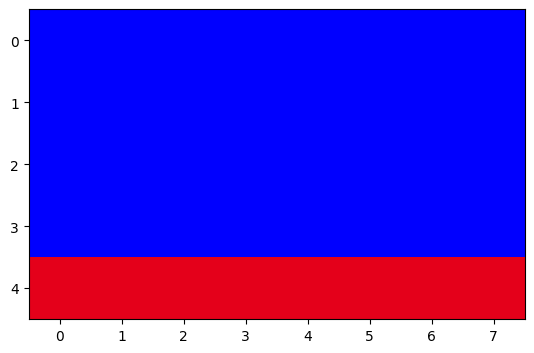

In [6]:
image = create_steak(5,8,.08)
plt.imshow(get_color_map(image))

In [7]:
np_image = np.array(image)

In [8]:
print(np_image)

[[[2.5000e+01 1.7881e-01 2.0082e+03 1.3299e+03 0.0000e+00]
  [2.5000e+01 1.7881e-01 2.0082e+03 1.3299e+03 0.0000e+00]
  [2.5000e+01 1.8071e-01 1.9842e+03 9.2559e+02 0.0000e+00]
  [2.5000e+01 1.7881e-01 2.0082e+03 1.3299e+03 0.0000e+00]
  [2.5000e+01 1.7881e-01 2.0082e+03 1.3299e+03 0.0000e+00]
  [2.5000e+01 1.8071e-01 1.9842e+03 9.2559e+02 0.0000e+00]
  [2.5000e+01 1.7881e-01 2.0082e+03 1.3299e+03 0.0000e+00]
  [2.5000e+01 1.7881e-01 2.0082e+03 1.3299e+03 0.0000e+00]]

 [[2.5000e+01 1.7881e-01 2.0082e+03 1.3299e+03 0.0000e+00]
  [2.5000e+01 1.7881e-01 2.0082e+03 1.3299e+03 0.0000e+00]
  [2.5000e+01 1.8071e-01 1.9842e+03 9.2559e+02 0.0000e+00]
  [2.5000e+01 1.7881e-01 2.0082e+03 1.3299e+03 0.0000e+00]
  [2.5000e+01 1.7881e-01 2.0082e+03 1.3299e+03 0.0000e+00]
  [2.5000e+01 1.7881e-01 2.0082e+03 1.3299e+03 0.0000e+00]
  [2.5000e+01 1.8071e-01 1.9842e+03 9.2559e+02 0.0000e+00]
  [2.5000e+01 1.7881e-01 2.0082e+03 1.3299e+03 0.0000e+00]]

 [[2.5000e+01 1.8071e-01 1.9842e+03 9.2559e+02 0.000

In [9]:
step_pixel(np_image,3,1)

np.float64(25.00468666481562)

In [10]:
def plot_heatmaps(image,timestep,interval,total_duration):
    n_plots = total_duration / interval
    i = 0
    arr_of_images = []
    while i < n_plots:
        print(f"Creating plot no. {i+1} ...")
        j = 0
        while j < (interval / timestep):
            step(image,timestep)
            j += 1
        print(f"Plot no. {i+1} created")
        arr_of_images.append(copy.deepcopy(image))
        i += 1
    return arr_of_images

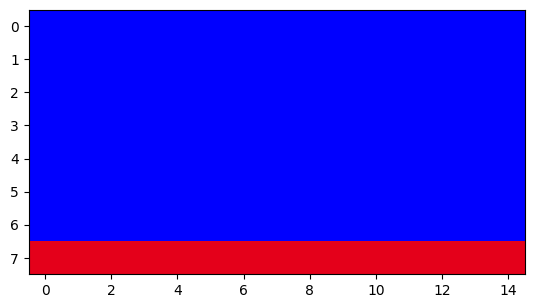

In [11]:
image = create_steak(8,15,.01)
plt.imshow(get_color_map(image))

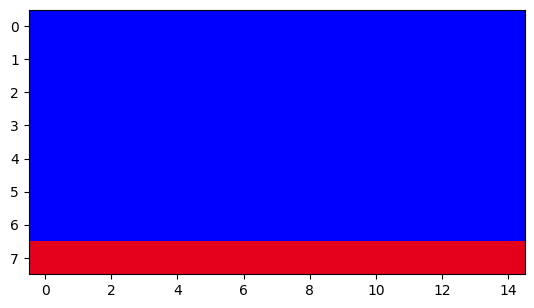

In [12]:
step(image)
plt.imshow(get_color_map(image))

In [ ]:
arr = plot_heatmaps(image,0.1,1000,6000)
fig, ax = plt.subplots(nrows = 2, ncols = 3)

for i in range(len(ax)):
    for j in range(len(ax[0])):
        ax[i][j].imshow(get_color_map(arr[i*3 + j]))

fig.tight_layout()
plt.show()

Creating plot no. 1 ...
Plot no. 1 created
Creating plot no. 2 ...
Plot no. 2 created
Creating plot no. 3 ...
Plot no. 3 created
Creating plot no. 4 ...
Plot no. 4 created
Creating plot no. 5 ...


In [ ]:
arr[3][4][4]